In [107]:
import pandas as pd
import pymongo
import requests
from bs4 import BeautifulSoup
import time
import json
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split, cross_val_score

In [108]:
def games_in_a_month(df, player, month):
    return len(df['games'][player][month][0]['games'])

def is_in_fist_30_days(df, player, month, game):
    '''returns True if game was played within the first 30 days of signing up'''
    seconds_in_a_month = 2629743
    month_from_date_joined = df['joined'][player] + seconds_in_a_month
    time_of_game = df['games'][player][month][0]['games'][game]['end_time']
    
    return month_from_date_joined > time_of_game

def fourth_month_games_count(df, player, month, game):
    '''returns the count of games played in the in the 4th month since sign up'''
    seconds_in_a_month = 2629743
    three_months_from_date_joined = df['joined'][player] + (3 * seconds_in_a_month)
    four_months_from_date_joined = df['joined'][player] + (3.2 * seconds_in_a_month)
    time_of_game = df['games'][player][month][0]['games'][game]['end_time']
    
    game_count = 0
    if (time_of_game > three_months_from_date_joined) and (time_of_game > four_months_from_date_joined):
        game_count += 1
    return game_count

def games_in_first_month(df, player, month, game):
    '''returns a count of how many games were played by a user in the first 30 days since signing up'''
    games = 0
    if is_in_fist_30_days(df, player, month, game):
        games += 1
    return games

def rated_games(df, player, month, game):
    '''returns True if game was rated and it was played within the first 30 days of signing up'''
    if is_in_fist_30_days(df, player, month, game):
        return str(df['games'][player][month][0]['games'][game]['rated'])
    else:
        return 'invalid'
    
def time_class_games(df, player, month, game):
    '''returns type of time control if the game was played within the first 30 days'''
    if is_in_fist_30_days(df, player, month, game):
        return df['games'][player][month][0]['games'][game]['time_class']
    else:
        return 'invalid'
    
def rules_games(df, player, month, game):
    '''returns chess variation if the game was played within the first 30 days'''
    if is_in_fist_30_days(df, player, month, game):
        return df['games'][player][month][0]['games'][game]['rules']
    else:
        return 'invalid'
    
def eco_games(df, player, month, game):
    '''returns the eco code for opening played if the game was played in the first 30 days'''
    if is_in_fist_30_days(df, player, month, game):
        return df['games'][player][month][0]['games'][game]['eco'][31:].split('-')[0]
    else:
        return 'invalid'

def results_games(df, player, month, game):
    '''returns the result of the each game played'''
    result_for_white = df['games'][player][month][0]['games'][game]['white']['result']
    result_for_black = df['games'][player][month][0]['games'][game]['black']['result']
    
    if is_in_fist_30_days(df, player, month, game):
        if df['games'][player][month][0]['games'][game]['white']['username'] == df['username'][0]:
            return result_for_white
        else:
            return result_for_black
    else:
        return 'invalid'

def rating_games(df, player, month, game):
    '''returns the result of the each game played'''
    rating_for_white = df['games'][player][month][0]['games'][game]['white']['rating']
    rating_for_black = df['games'][player][month][0]['games'][game]['black']['rating']
    
    if is_in_fist_30_days(df, player, month, game):
        if df['games'][player][month][0]['games'][game]['white']['username'] == df['username'][0]:
            return int(rating_for_white)
        else:
            return int(rating_for_black)
    else:
        return 0

def make_columns(features, df, index):
    '''Counts the appearances of each type of outcome then creates a column in the dataframe corresponding to
    that outcome and filling in the number of occurrences for each player
    Params:
        features: List of each outcome ex: [c, a, a, d, d, a, d, c, j]
        df: pandas dataframe
        index: index to located each player
    '''
    counters = Counter()
    for feature in features:
        counters[feature] += 1

    for counter in counters:
        df.loc[index, counter] = counters[counter]


def parse_games(df, verbose=False):
    '''Pull out stats from the column containing games and add columns to the datafram inplace for the stats
    Params:
        df: pandas dataframe
    Keyword Args:
        verbose: if True, print player indices as they are parsed, default is False
    '''
    player_idxes = range(df.shape[0])
    for player in player_idxes:
        if verbose:
            print(player)
        rated = []
        time_class = []
        rules = []
#         eco = []
        results = []
        ratings = [0,]
        fourth_month_games = 0
        first_month_games = 0
        for month in range(5):
            try:
                for game in range(games_in_a_month(df, player, month)):
                    if is_in_fist_30_days(df, player, month, game):
                        try:
                            rated.append(rated_games(df, player, month, game))
                        except KeyError:
                            continue
                        try:
                            rules.append(rules_games(df, player, month, game))
                        except KeyError:
                            continue
    #                     try:
    #                         eco.append(eco_games(df, player, month, game))
    #                     except KeyError:
    #                         continue
                        try:
                            results.append(results_games(df, player, month, game))
                        except KeyError:
                            continue
                        try:
                            ratings.append(rating_games(df, player, month, game))
                        except KeyError:
                            continue
                        try:
                            fourth_month_games += fourth_month_games_count(df, player, month, game)
                        except KeyError:
                            continue
                        try:
                            first_month_games += games_in_first_month(df, player, month, game)
                        except KeyError:
                            continue
            except (KeyError, IndexError):
                continue

        print(ratings)
        df.loc[player, 'fourth_month_games'] = fourth_month_games
        df.loc[player, 'first_month_games'] = first_month_games
        df.loc[player, 'highest_rating'] = max(ratings)
        df.loc[player, 'minimum_rating'] = min([rating for rating in ratings if rating > 0])
        
        make_columns(rated, df, player)
        make_columns(rules, df, player)
#         make_columns(eco, df, player)
        make_columns(results, df, player)
            
        
def add_features(df):
    '''make all feature columns and target column
    Params:
        df: pandas datafram
    Returns:
        df: dataframe with all feature columns and target column
    '''
    #parse games column
    parse_games(df)
    
    #rename True and False columns to rated and unrated
    df.rename(columns={'True': 'rated', 'False': 'unrated'}, inplace=True)

    #create inactive column (1 = inactive, 0 = active) inactive if they have not played a game in the fourth month since signup
    df['inactive'] = df['fourth_month_games'].apply(lambda x: 1 if x == 0 else 0)

    #create columns has_name, has_location, has_avatar
    df['has_name'] = df['name'].apply(lambda x: 0 if x != x else 1)
    df['has_location'] = df['location'].apply(lambda x: 0 if x != x else 1)
    df['has_avatar'] = df['avatar'].apply(lambda x: 0 if x != x else 1)

    #make a basic account type column
    df['is_basic'] = df['status'].apply(lambda x: 1 if x == 'basic' else 0)

    #make a premium account type column
    df['is_premium'] = df['status'].apply(lambda x:  1 if x == 'premium' else 0)
    
#     #win percentage
#     df['win_percentage'] = df['win'] / df['first_month_games']
    
#     #rated percentage
#     df['rated_percentage'] = df['rated'] / df['first_month_games']
    return df
    
    
def make_X_y(df):
    '''returns:
            X: all important feature columns
            y: target column, 1 (inactive: less than 2 games played during the last month) or 0 (active)'''
    #assign X and y variables
    y = df['inactive']
    
    X = df[['first_month_games', 'chess', 'resigned', 'checkmated', 'timeout',
       'abandoned', 'timevsinsufficient', 'stalemate', 'insufficient',
       'unrated', 'repetition', 'agreed', 'bughouse', 'crazyhouse',
       'kingofthehill', 'chess960', 'threecheck', 'has_name', 'has_location', 'has_avatar',
       'is_basic', 'is_premium', 'highest_rating']]
    
    return (X, y)

In [112]:
df.head()

,@id,_id,avatar,chess960_daily,chess_blitz,chess_bullet,chess_daily,chess_rapid,country,followers,...,True,chess,checkmated,resigned,timeout,win,abandoned,timevsinsufficient,stalemate,insufficient
0,https://api.chess.com/pub/player/babu500,5afa039f098388ad5ff6a3a1,NaN,NaN,"{'last': {'rating': 777, 'date': 1525820389, '...",NaN,"{'last': {'rating': 1200, 'date': 1516320601, ...","{'last': {'rating': 974, 'date': 1522794278, '...",https://api.chess.com/pub/country/US,1,...,10.0,10.0,3.0,2.0,1.0,4.0,NaN,NaN,NaN,NaN
1,https://api.chess.com/pub/player/0rlandomagic,5afa05ce098388c83c3f08fa,NaN,"{'last': {'rating': 1257, 'date': 1526259679, ...","{'last': {'rating': 1800, 'date': 1526089345, ...","{'last': {'rating': 2117, 'date': 1526323151, ...","{'last': {'rating': 1425, 'date': 1525869836, ...",NaN,https://api.chess.com/pub/country/US,13,...,63.0,63.0,12.0,10.0,10.0,27.0,1.0,1.0,1.0,1.0
2,https://api.chess.com/pub/player/0ldtower,5afa063e098388c83c3f08fc,NaN,NaN,NaN,NaN,NaN,NaN,https://api.chess.com/pub/country/US,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,https://api.chess.com/pub/player/0xvyper,5afa0641098388c83c3f08fe,NaN,NaN,"{'last': {'rating': 705, 'date': 1526217305, '...",NaN,NaN,"{'last': {'rating': 870, 'date': 1516238541, '...",https://api.chess.com/pub/country/US,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,https://api.chess.com/pub/player/101arrowz,5afa0642098388c83c3f08ff,https://images.chesscomfiles.com/uploads/v1/us...,NaN,"{'last': {'rating': 851, 'date': 1526169302, '...","{'last': {'rating': 1183, 'date': 1525929576, ...","{'last': {'rating': 862, 'date': 1516843804, '...","{'last': {'rating': 828, 'date': 1518305784, '...",https://api.chess.com/pub/country/US,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
mc = pymongo.MongoClient()  # Connect to the MongoDB server using default settings
db = mc['chess_predictions']  # Use (or create) a database called 'chess_predictions'

print('import data from mongoDB to pandas dataframe')
#get data from mongoDB and put into dataframe
df = pd.DataFrame(list(db['players'].find()))

print('done importing from mongoDB')

#remove duplicate users by player_id
df.drop_duplicates(subset='player_id', inplace=True)

# #reset the index
df.reset_index(drop=True, inplace=True)

print('now making features and target')

# make features and target
add_features(df)

import data from mongoDB to pandas dataframe
done importing from mongoDB
now making features and target
[0, 953, 830, 1200, 770, 733, 896, 998, 1058, 1097, 1016]
[0, 951, 1318, 1171, 1223, 1117, 1387, 951, 1368, 945, 1329, 1375, 1259, 1484, 1345, 1400, 1439, 1577, 1651, 1651, 1555, 1434, 1542, 1561, 1442, 1430, 1584, 1602, 1584, 1465, 1601, 1637, 1648, 1587, 1644, 1589, 1637, 1609, 1554, 1651, 1621, 1566, 1639, 1648, 1641, 1614, 1640, 1689, 1722, 1675, 1660, 1653, 1653, 1733, 1668, 1598, 1693, 1676, 1684, 1703, 1700, 1844, 1695, 1703]
[0]


ValueError: min() arg is an empty sequence

In [47]:
fill_df = df.fillna(0)
# #create features and target dataframes
X, y = make_X_y(fill_df)

# #make a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)


random_forest_testrun = RandomForestClassifier()
random_forest_testrun.fit(X_train, y_train)
y_predict = random_forest_testrun.predict_proba(X_test)

print(roc_auc_score(y_test, y_predict[:, 1]))

print(cross_val_score(random_forest_testrun, X_test, y_test, cv=20))

0.7242843409527879
[0.8        0.75       0.88888889 0.83333333 0.83333333 0.77777778
 0.77777778 0.77777778 0.94444444 0.88888889 0.72222222 0.77777778
 0.94444444 0.83333333 0.83333333 0.83333333 0.83333333 0.88888889
 0.88888889 0.83333333]


In [68]:
gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(X_train, y_train)
gradient_y_predict = gradient_boost.predict_proba(X_test)

print(roc_auc_score(y_test, gradient_y_predict[:, 1]))
# print(cross_val_score(gradient_boost, X_test, y_test, cv=20))

0.7616962187566759


In [77]:
logistic_model = LogisticRegressionCV()
logistic_model.fit(X, y)
logistic_y_predict = logistic_model.predict_proba(X)

print(roc_auc_score(y, logistic_y_predict[:, 1]))
# print(cross_val_score(logistic_model, X_test, y_test, cv=20))

0.8321922651649566


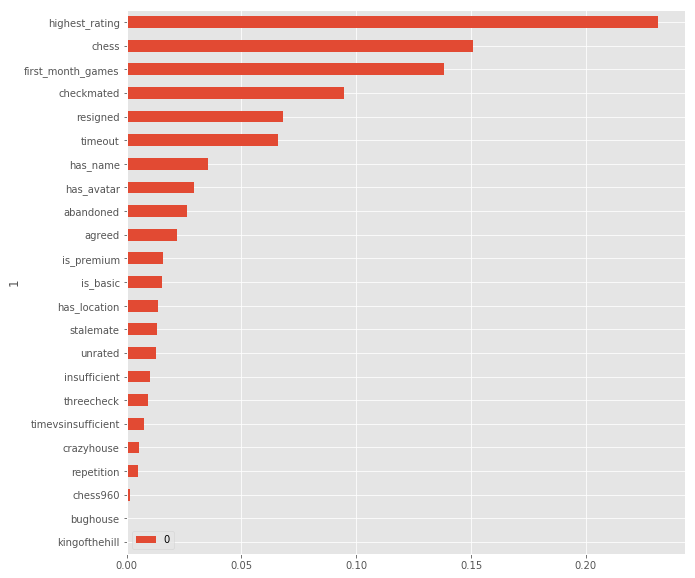

In [38]:
def rf_best_features(X, y, n_features):
    
    x_columns = X

    y_true = y

    rf_model = RandomForestClassifier(n_estimators=100)
    
    rf_model.fit(x_columns, y_true)
    
    feature_importances = {}
    
    for i in range(len(rf_model.feature_importances_)):
        
        feature_importances[x_columns.columns[i]] = rf_model.feature_importances_[i]
    
    
    top_features = Counter(feature_importances).most_common(n_features)
    
    values = [feature[1] for feature in top_features]
    
    features = [feature[0] for feature in top_features]
    
    return values, features


def plot_best_features(values, features, figsize_x=10, figsize_y=10):
    
    new_df = pd.DataFrame(list(zip(values,features))).set_index(1).sort_values(0)

    new_df.plot.barh(figsize=(figsize_x,figsize_y))

values, features = rf_best_features(X_test, y_test, 26)
plot_best_features(values, features)

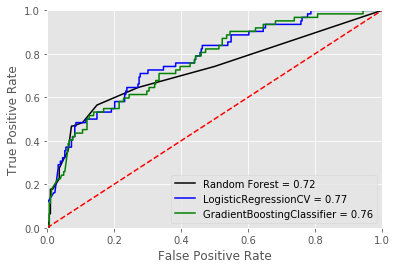

In [70]:
fig, ax = plt.subplots()

rand_y_pred = random_forest_testrun.predict_proba(X_test)

rand_fpr, rand_tpr, rand_threshold = roc_curve(y_test, rand_y_pred[:,1])
rand_area_under_curve = auc(rand_fpr, rand_tpr)

logistic_y_pred = logistic_model.predict_proba(X_test)

logistic_fpr, logistic_tpr, logistic_threshold = roc_curve(y_test, logistic_y_pred[:,1])
logistic_area_under_curve = auc(logistic_fpr, logistic_tpr)

gradient_y_pred = gradient_boost.predict_proba(X_test)

gradient_fpr, gradient_tpr, gradient_threshold = roc_curve(y_test, gradient_y_pred[:,1])
gradient_area_under_curve = auc(gradient_fpr, gradient_tpr)

ax.plot(rand_fpr, rand_tpr, 'k', label = f'Random Forest = {rand_area_under_curve:.2f}')
ax.plot(logistic_fpr, logistic_tpr, 'b', label = f'LogisticRegressionCV = {logistic_area_under_curve:.2f}')
ax.plot(gradient_fpr, gradient_tpr, 'g', label = f'GradientBoostingClassifier = {gradient_area_under_curve:.2f}')

ax.legend(loc = 'lower right')
ax.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('AUC')
plt.show()


# # plot_roc([random_forest_testrun, gradient_boost, logistic_model], X_test, y_test)
# plot_roc(random_forest_testrun, X_test, y_test)
# plot_roc(gradient_boost, X_test, y_test)
# plot_roc(logistic_model, X_test, y_test)